# ***Computer Vision Project : Binary Classification using CIFAR10 dataset***

### Group (TPE)

- **Karbich Aya**
- **Essaadi Hajar**


* *For our project, we'll be training a Convolutional Neural Network for a binary classification task using the CIFAR10 dataset. Our objective is to categorize objects into two classes: those that can fly (class 1, including birds and airplanes) and those that cannot fly (class 0, including frogs, deer, trucks, etc.). To complete this task, we'll need to choose the right CNN architecture, an appropriate loss function, and a solid evaluation strategy. We'll assess our model's performance using precision, recall, F1 score, accuracy, and a confusion matrix on a test set.*



## Importing the necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.filters import unsharp_mask
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

## Load CIFAR-10 dataset


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Print the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

170498071/170498071 [==============================] - 3s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


## Apply Unsharp Mask to an image to enhance the sharpness and edges of the images.

In [ ]:
def apply_unsharp_mask(image, radius=1.5, amount=1.5):
    return unsharp_mask(image, radius=radius, amount=amount)

In [4]:
def preprocess_images(images):
    sharpened_images = []
    for img in images:
        img_float = img_as_float(img)
        sharpened_img = unsharp_mask(img_float, radius=1.0, amount=1.0)
        sharpened_images.append(sharpened_img)
    return np.array(sharpened_images)

# Preprocess the training and test images
x_train_sharpened = preprocess_images(x_train)
x_test_sharpened = preprocess_images(x_test)

# Print the shape of the sharpened data
print(f"Sharpened training data shape: {x_train_sharpened.shape}")
print(f"Sharpened test data shape: {x_test_sharpened.shape}")

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


Sharpened training data shape: (50000, 32, 32, 3)
Sharpened test data shape: (10000, 32, 32, 3)


## Plot images with original labels

Images of objects that can fly:


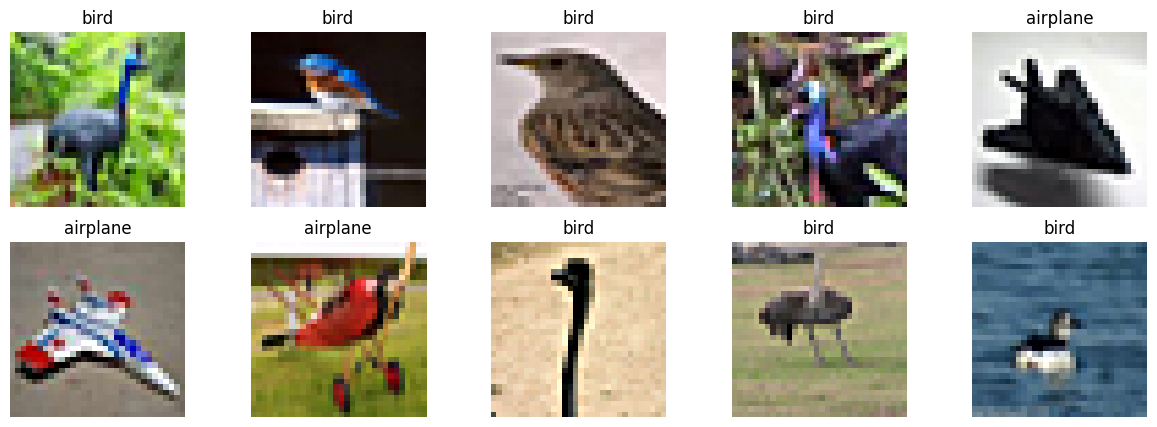

Images of objects that cannot fly:


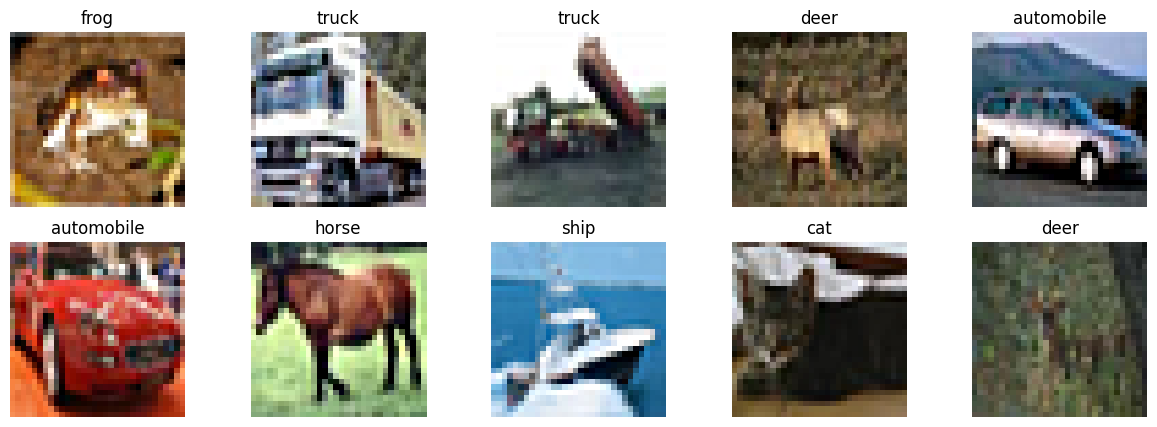

In [5]:
def plot_raw_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.show()

# Class names for CIFAR-10
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a subset of raw images and their labels
num_images = 10

# Plot images that "can fly" (airplane and bird)
can_fly_indices = np.where((y_train == 0) | (y_train == 2))[0] #airplane or bird
print("Images of objects that can fly:")
plot_raw_images(x_train_sharpened[can_fly_indices][:num_images], y_train[can_fly_indices][:num_images], cifar10_class_names)

# Plot images that "cannot fly" (all other classes)
cannot_fly_indices = np.where((y_train != 0) & (y_train != 2))[0] #all the other labels
print("Images of objects that cannot fly:")
plot_raw_images(x_train_sharpened[cannot_fly_indices][:num_images], y_train[cannot_fly_indices][:num_images], cifar10_class_names)


## Convert labels to boolean values



#### We create binary labels for our classification task. Specifically, it checks whether each label in y_train and y_test is 0 (airplane) or 2 (bird). If the label is 0 or 2, it is considered as 1 (can fly), otherwise, it is considered as 0 (cannot fly).

===> it is needed to turn this problem into a binary classification problem can fly as 1 can't fly as 0.

In [6]:
y_train_binary = (y_train == 0) | (y_train == 2)  # 0: airplane, 2: bird
y_test_binary = (y_test == 0) | (y_test == 2)

## Convert boolean labels to integer labels (0 or 1)


#### The boolean arrays resulting from the previous step are converted to integers (0 or 1). The astype(int) function converts the boolean values (True or False) to integers (1 or 0)
===> it's needed because neural networks, require numerical input. Boolean values need to be converted to integers for the model to process them correctly.

In [7]:
y_train_binary = y_train_binary.astype(int).reshape(-1)
y_test_binary = y_test_binary.astype(int).reshape(-1)

## Normalize the images to the range [0, 1]


#### This scales the pixel values of the images from the range [0, 255] to the range [0, 1] by dividing by 255.0.
===> it's needed because Neural networks typically perform better with normalized input data. Normalizing the pixel values helps in faster convergence during training and can lead to better performance. It also ensures that the model weights do not grow too large during training, which can help with numerical stability.

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [11]:
# Print the shape of the preprocessed data
print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed training labels shape: {y_train_binary.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")
print(f"Preprocessed test labels shape: {y_test_binary.shape}")

Preprocessed training data shape: (50000, 32, 32, 3)
Preprocessed training labels shape: (50000,)
Preprocessed test data shape: (10000, 32, 32, 3)
Preprocessed test labels shape: (10000,)


In [12]:
y_test_binary[0] #-> class1

0

## Model

### Overview of the model

*   Split the original training data (x_train and y_train_binary) into training and validation sets, with 80% of the data for training (x_train_split and y_train_split) and 20% for validation (x_val and y_val).

*   ImageDataGenerator is used for data augmentation, applying random rotations, width and height shifts, and horizontal flips to the training images. This helps the model generalize better by providing more varied training examples

*   Input Layer: Expects images of shape (32, 32, 3).

*   Convolutional layer with 32/32/64 filters each followed by a ReLU activation function, batch normalization, max pooling, and dropout.

*   kernel_regularizer=l2(0.001): L2 regularization to prevent overfitting.

*   MaxPooling2D: Reduces the spatial dimensions of the feature maps.

*   Dropout: Randomly drops units to prevent overfitting.

*   Flatten: Flattens the 3D feature maps to 1D feature vectors.

*   EarlyStopping: Stops training if the validation loss does not improve for 10 epochs, restoring the best weights.

In [14]:
# Split the data into training and validation sets
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train_binary, test_size=0.2, random_state=40)

# We check data shapes and ensure that evrything is good shapes are correct
print(f'x_train_split shape: {x_train_split.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_train_split shape: {y_train_split.shape}')
print(f'y_val shape: {y_val.shape}')

# Define the ImageDataGenerator for data augmentation, this will help us limit overfitting
datagen = ImageDataGenerator(
    rotation_range=20, # Randomly rotate 
    width_shift_range=0.2, # Randomly shift the width 
    height_shift_range=0.2, # Randomly shift the height 
    horizontal_flip=True # Randomly flip images horizontally
)

# Fit the data generator on the training data
datagen.fit(x_train_split)

# Define the CNN model
model = Sequential([
    Input(shape=(32, 32, 3)),  # CIFAR-10 image shape
    Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)), 
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(), # Flatten the 3D output to 1D
    Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5), # Dropout with 50% rate

    Dense(1, kernel_initializer='he_normal', kernel_regularizer=l2(0.001)),  # Single output unit for binary classification
    Activation('sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary labels
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with specified learning rate
    metrics=['accuracy']  # Track accuracy
)

# Display the model summary
print(model.summary())

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model using the data generator
history = model.fit(
    datagen.flow(x_train_split, y_train_split, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=30,  # We increase epochs to allow the model to train longer with early stopping
    callbacks=[early_stopping, reduce_lr]
)


x_train_split shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
y_train_split shape: (40000,)
y_val shape: (10000,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0      

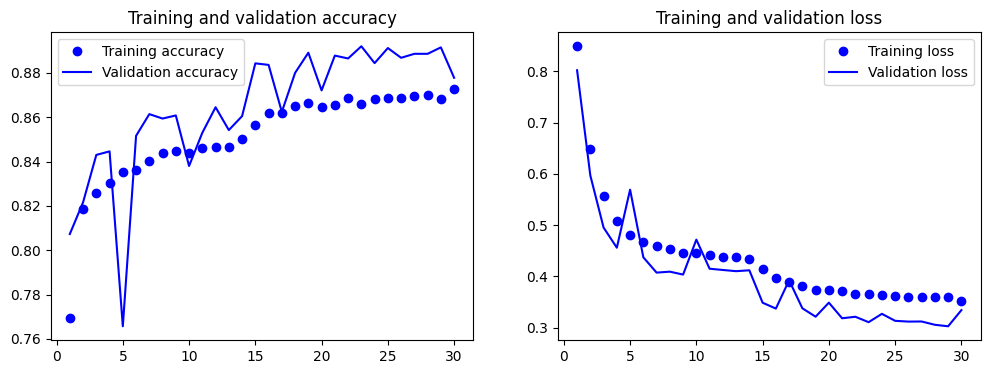

In [17]:
# Plot the learning curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_learning_curves(history)

### Conclusions

##### The provided graphs plot the training and validation accuracy / loss over 30 epochs. 
- In the accuracy graph, we observe that the training accuracy improves steadily, reaching approximately 0.88, while the validation accuracy shows a more fluctuating pattern, stabilizing around 0.86. This fluctuation in validation accuracy suggests occasional overfitting, where the model performs well on training data but not consistently on validation data. 
- In the loss graph, both training and validation loss decrease rapidly in the initial epochs, indicating effective learning. The training loss continues to decline smoothly, whereas the validation loss fluctuates slightly before stabilizing. 


## Evaluate the model on the testing set

313/313 [==============================] - 7s 20ms/step
Precision: 0.91701244813278
Recall: 0.442
F1 Score: 0.5964912280701754
Accuracy: 0.8804


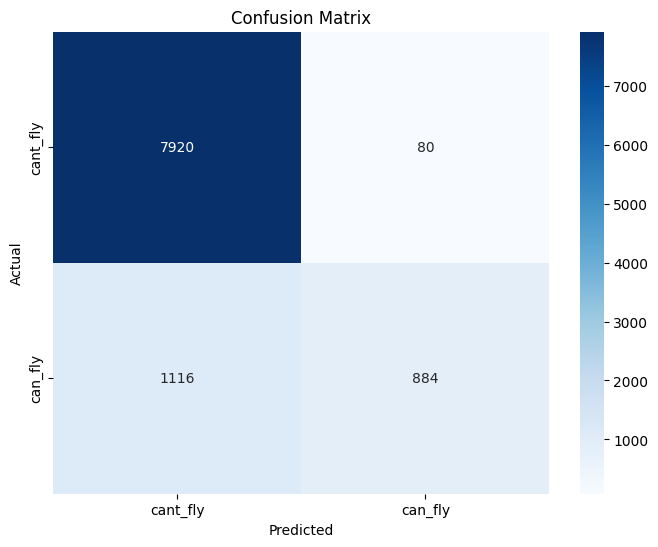

In [16]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32") # compare the predicted probability to the threshold 0.5

# Calculate evaluation metrics
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)

# Print the evaluation metrics
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['cant_fly', 'can_fly'], yticklabels=['cant_fly', 'can_fly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### The majority of the instances belong to the "can't fly" class, and the model performs well in predicting these (high TN count). However, the model struggles significantly with the "can fly" class, resulting in a high number of false negatives (FN).

===> We observe that 1116 actual can fly instances are predicted as can't fly, which is a problem this can be due to **imbalance and diversity of examples in the "can fly" class (1) compared to the "can't fly" class (0)**

- If there are significantly more examples of "can't fly" than "can fly," the model may become biased towards predicting the majority class.

- Also the lack of diversity because the "can fly" class only groups objects (birds and airplanes), while the can't fly class groups more objects (frog, deer, truck, etc..). Therefore the model may not learn the varied features required to accurately predict this class.


## Let's see the class distribution

In [19]:
import numpy as np

# Assuming y_train_binary is your NumPy array of labels
unique, counts = np.unique(y_train_binary, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Class distribution in training data:", class_counts)


Class distribution in training data: {0: 40000, 1: 10000}


### => As we can see class 0 (can't fly) has far more instances than the class 1 (can fly)